In [18]:
folder_names = ['/Users/yoshi/Dropbox/measurements/data/pr10_re4100_down/',
                '/Users/yoshi/Dropbox/measurements/data/pr10_re5400_down/',
                '/Users/yoshi/Dropbox/measurements/data/pr10_re6500_down/',
                '/Users/yoshi/Dropbox/measurements/data/pr10_re8100_down/',
                '/Users/yoshi/Dropbox/measurements/data/pr10_re9600_down/',
                '/Users/yoshi/Dropbox/measurements/data/pr10_re12600_down/',
                '/Users/yoshi/Dropbox/measurements/data/pr10_re15800_down/',
                '/Users/yoshi/Dropbox/measurements/data/pr10_re18600_down/',
                
                '/Users/yoshi/Dropbox/measurements/data/pr10_re4100_up/',
                '/Users/yoshi/Dropbox/measurements/data/pr10_re5400_up/',
                '/Users/yoshi/Dropbox/measurements/data/pr10_re6500_up_b/',
                '/Users/yoshi/Dropbox/measurements/data/pr10_re8100_up/',
                '/Users/yoshi/Dropbox/measurements/data/pr10_re9600_up/',
                '/Users/yoshi/Dropbox/measurements/data/pr10_re12600_up/',
                '/Users/yoshi/Dropbox/measurements/data/pr10_re15800_up/',
                '/Users/yoshi/Dropbox/measurements/data/pr10_re18600_up/']
prandtl = 10

In [1]:
#Compare with DNS
folder_names = ['../../measurements/pr10_DNS/pr10_re4100_up/',
                '../../measurements/pr10_DNS/pr10_re6500_up/',
                '../../measurements/pr10_DNS/pr10_re9600_up/',
                '../../measurements/pr10_DNS/pr10_re12600_up/']
prandtl = 10

In [ ]:
#Re4100
folder_names = ['../../measurements/pr10/pr10_re4100_DNS/',
                '../../measurements/pr10/pr10_re4100_wave_b/',
                
                '../../measurements/data/pr10_re4100_down/',
                '../../measurements/data/pr10_re4100_up/',
                
                '../../measurements/pr10_DNS/pr10_re4100_up/']
prandtl = 10

In [12]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import csv
import os
import codecs
import time
import seaborn as sns
import statistics 
import scipy.stats

rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
fontsize_legend = 16 
linesize_legend = 4 
plt.rc('legend',fontsize=fontsize_legend)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

In [13]:
# Material properties for Ethylen Glycol
A = 2.0148;
B = 4.50E-3;
def cp(T):
    cp = (A + B * (T+273.15));
    return cp
def cp_K(T):
    cp_K = A + B * (T);
    cp_K =  cp_K *1000;##???
    return cp_K
C = 0.2134;
D = 6.071E-4;
def Lambda(T):
    Lambda = C + D * (T+273.15);
    return Lambda
def Lambda_K(T):
    Lambda_K = C + D * (T);
    return Lambda_K
E = 1.1001E-4;
F = 325.85;
G = -207.30;
def mu(T):
    mu = E * np.exp( F / ( (T+273.15) + G) );
    return mu
def mu_K(T):
    mu_K = E * np.exp( F / ( (T) + G) );
    return mu_K
H = 1268.28;
I = -0.66;
def rho(T):
    rho = H + I * (T+273.15);
    return rho
def rho_K(T):
    rho_K = H + I * (T);
    return rho_K
def nu(T):
    nu = mu(T)/rho(T);
    return nu
def nu_K(T):
    nu_K = mu_K(T)/rho_K(T);
    return nu
def Pr(T):
    Pr = ( mu(T) * cp(T) * 1000 ) / Lambda(T);
    return Pr
def Pr_K(T):
    Pr_K = ( mu_K(T) * cp_K(T)) / Lambda_K(T);
    return Pr

def calculate_mean(data):
    s = sum(data)
    N = len(data)
    mean =s/N
    return mean
def find_difference(data):
    mean = calculate_mean(data)
    diff = []
    for num in data:
        diff.append(num-mean)
    return diff
def calculate_variance(data):
    diff = find_difference(data)
    squared_diff = []
    for d in diff:
        squared_diff.append(d**2)
    sum_squared_diff = sum(squared_diff)
    variance = sum_squared_diff/len(data)
    return variance

#Experimental Facilities
di=12E-3
da=15E-3
ri = di/2
ra = da/2
disoa = 90E-3
L=2
V=(da**2-di**2)*np.pi/4*L
Ageo_MS = di*np.pi*L #円菅内部の試験部表面積
Ugeo_MS = di*np.pi #円菅内面積
Ageo_quer = di**2*np.pi/4
x_pos_TPt100_new =      [0.030, 2.400, 2.600, 2.800, 3.000, 3.000, 3.140, 5.500]
x_pos_TPt100_new_tmp =  [2.400, 2.600, 2.800, 3.000, 3.140]
TPT100_new_tmp =        [0,0,0,0,0]
xTin  = 0.03
xTout = 5.50
x_MS_in = 1.2
x_MS_out = 3.2

# conduction equation for inner wall temperatuer
DeltaK = 0.065E-3
Lambda_N = 20#!!!!!!!!!!!!!!!!!!!!!!!!
Lambda_C = 0.16 #thermal conductivity[W/mK] of capton tape
Lambda_iso = 0.055 #thermal conductivity[W/mK] of glass wool, outer isolation
riso = 0.05 #thickness of isolation
def T1(r,qv,qzu,TN,Ta): #temperature distribution in pipe(ri << r << ra)
    T1 = (qzu/(2*Lambda_N)*ra**2)*(0.5-0.5*(r/ra)**2+np.log(r/ra)) + Ta - qv/Lambda_N*(ra+DeltaK)*(Lambda_N/Lambda_C*np.log(ra/(ra+DeltaK))+np.log(r/ra))
    return T1
def T2(r,qv,Ta):        #temperature distribution in capton tape(ra << r << ra+DeltaK)
    T2 = - qv/Lambda_C*(ra+DeltaK)*np.log(r/(ra+DeltaK)) + Ta
    return T2

In [14]:
where = folder_names[0]
n_samples  = 0
for f_name in sorted(os.listdir(where)):
    n_samples = n_samples + 1
    number_of_stations = np.size(folder_names)
    Re_M_ave = np.zeros(number_of_stations)
    cf_M_ave = np.zeros(number_of_stations)
    Nu_M_ave = np.zeros(number_of_stations)
    Pr_w_ave = np.zeros(number_of_stations)
    Pr_m_ave = np.zeros(number_of_stations)
    T_m_ave  = np.zeros(number_of_stations)
    T_w_ave  = np.zeros(number_of_stations)
    mu_m_ave = np.zeros(number_of_stations)
    mu_w_ave = np.zeros(number_of_stations)
    drho_ave = np.zeros(number_of_stations)
    rho_m_ave= np.zeros(number_of_stations)
    rho_w_ave= np.zeros(number_of_stations)
    qw_ave   = np.zeros(number_of_stations)
    P_MS_ave = np.zeros(number_of_stations)
    I_MS_ave = np.zeros(number_of_stations)
    Qin_out_ave= np.zeros(number_of_stations)
    mdot_ave = np.zeros(number_of_stations)
    Wmean_ave= np.zeros(number_of_stations)
    rho_m_ave= np.zeros(number_of_stations)
    rho_w_ave= np.zeros(number_of_stations)
    
    Re_m_samples = []
    cf_m_samples = []
    Nu_samples = []
    delta_NuMessung_samples = []

for j in range(0,number_of_stations):
    filename_list        = []
    T_in_list            = []
    T_out_list    = []
    Tw_list       = []
    Tm_list       = []
    mdot_list     = []
    qw_list              = []
    Re_m_list            = []
    Re_w_list            = []
    ReTau_list           = []
    Pr_m_list            = []
    Pr_w_list            = []
    NuMessung_list       = []
    cf_M_list            = []
    delta_NuMessung_list = []
    delta_cf_M_list = []
    df_list_all = []
    delta_p_list = []
    mu_m_list = []
    mu_w_list = []
    I_MS_list = []
    Nu_turb_Gni4Tau_list = []
    P_MS_list=[]
    Qin_out_list=[]
    Wmean_list=[]
    rho_w_list = []
    rho_m_list = []
    
    where = folder_names[j]
    
    for fname in sorted(os.listdir(where)):
        filename = where + fname
        if filename == where + 'rubbish':
            continue
        elif filename == where + '.DS_Store':
            continue
        elif filename == where + '.DS_Store.txt':
            continue
        else:
            txt = codecs.open(filename, encoding ='cp1252')
            data = np.loadtxt(txt, skiprows = 1)
            Tsa = data[:,0] #Temperatur aussen: Ts_aussen / °C
            Tsi = data[:,1] #Temperatur innen: Ts innen / °C
            Ti = data[:,2] #Fluidtemperatur: T / °C
            m_dot_C1 = data[0,3] #Massenstrom: m_dot C1 / kg/h
            m_dot_C2 = data[0,4] #Massenstrom: m_dot C2 / kg/h
            Re_C1 = data[0,5] #Re C1 / -
            Re_C2 = data[0,6] #Re C2 / -
            v_C1 = data[0,7] #Geschwindigkeit: v C1 / m/s
            v_C2 = data[0,8] #Geschwindigkeit: v C2 / m/s
            U_MS = data[0,9] #Spannungsabfall Messstrecke: U_MS / V
            I_MS = data[0,10] #Strom Messstrecke: I_MS / A
            P_MS = data[0,11] #Leistung Messstrecke: P_MS / W
            q = data[0,12] #spzifische Leistung: q / W/m3
            P1 = data[0,13] #Druckmessung: P1 / Pa
            P2 = data[0,14] #Druckmessung: P2 / Pa
            dp = data[0,15] #Differenzdruck: dp / bar
            nu_Fluid = data[0,16] #kin. Viscositaet Fluid: nu / m2/s
            rho_Fluid = data[0,17] #Dichte Fluid: rho / kg/m3
            Lambda_Fluid = data[0,18] #Waermeleitfaehigkeit Fluid: lambda / W/mK
            cp_Fluid = data[0,19] #spez. Waermekapazitaet Fluid: cp /J/kgK
            Pr_Fluid = data[0,20] #Pr / -
            Lambda_Rohr = data[0,21] #Waermeleitfaehigkeit Rohr: lambda / W/mK
            Nu_Fluid = data[0,22] #Nu / -
            I1 = data[0,23] #Strom I / A
            U1 = data[0,24] #Spannung U / V
            dp_T1 = data[0,25] #Re_tau / - 関数名とtxtが合っていない？
            dp_T2 = data[0,26] #Re_tau_Pet / -　関数名とtxtが合っていない？
            dp_T3 = data[0,27] #dp Pet / Pa
            #Mittel (U*I) mean P / W
            Pm = data[0,28] #Mittel (U*I) mean P / W
            TPT100_a_old = data[:5,29]#PT100 T aussen(5 value)
            TPT100_i_old = data[:5,30]#PT100 T innen(5 value)
            TPT100_m_old = data[:5,31]#PT100 T mittel(5 value)
            TPT100_a_new = data[:8,38]#!!!!!!!!!!!!!
            TPT100_i_new = data[:8,39]
            TPT100_m_new = data[:8,40]
            NuPt100 = data[0,32] #Nu Pt100
            NuQm = data[0,33] #Nu Qm
            # zeta computation Einlesen
            ZRem100 = data[0,34] #zeta Re
            Zzeta100 = data[0,35] #zeta
            Zqm100 = data[0,36] #zeta qw
            TPT100_T5 = data[0,37] #PT100 T5
            TPT100_out = TPT100_a_new
            TPT100_in  = TPT100_i_new
            TPT100_mean= TPT100_m_new
            TPT100_new = TPT100_i_new
            Tm_aus = TPT100_new[7]
            Tm = Tm_aus
            n_samples  = n_samples  + 1
            
            # iteration to update the temperatuer dependent material properties --> new wall temperature 205-339
            # first loop doesnt include dq heat loss.
            for i in range(2):
                Tw = TPT100_new[6]
                T_iso = Ti[1]
                T_inf = Ti[6]
                Pr_w = Pr(Tw)
                Pr_w     = Pr(Tw)
                rho_w    = rho(Tw)
                nu_w     = nu(Tw)
                mu_w     = nu_w * rho_w
                cp_w     = cp(Tw)
                Lambda_w = Lambda(Tw)
                Pr_m     = Pr(Tm)
                rho_m    = rho(Tm)
                nu_m     = nu(Tm)
                mu_m     = nu_m * rho_m
                cp_m     = cp(Tm)
                Lambda_m = Lambda(Tm)
                
                dqhldT = 1
                zeta_mischer = 32.46
                Thl = (Tw + Tm)*0.5
                qhl = dqhldT * (Thl - T_iso)
                qhlm2 = qhl / (da*np.pi*5.45)
                Re_m = Re_C1
                Lambda_Pet = (1.8*np.log10(Re_m)-1.5)**(-2)
                
                #Specific heat capasity, cp mean
                T_in = TPT100_new[0] + 273.15
                T_out = TPT100_new[7] + 273.15
                Ac = 2.0148
                Bc = 4.50E-3
                cpm = (Ac*(T_out-T_in)+Bc/2*(T_out**2-T_in**2))/(T_out-T_in)*1000 #Eq(2.108)
                Wmean = Re_m*nu_m/di #velocisty
                mdot = m_dot_C1/3600

                TPT100_new_tmp[0] = TPT100_new[1]
                TPT100_new_tmp[1] = TPT100_new[2]
                TPT100_new_tmp[2] = TPT100_new[3]
                TPT100_new_tmp[3] = 0.5 * (TPT100_new[4] + TPT100_new[5])
                TPT100_new_tmp[4] = TPT100_new[6]
                fit = np.polyfit(x_pos_TPt100_new_tmp, TPT100_new_tmp,1)
                gradT_PT100 = fit[0]
                Q_Pt100 = gradT_PT100*mdot*cpm*L
                qUI = P_MS/Ageo_MS
                dqw2 = (Lambda_Pet*(5.45-2.92)/di + zeta_mischer) * rho_m * Wmean**2 /2 * Wmean * Ageo_quer - qhl*(5.45-2.53)/5.45
                
                Qin_out = mdot*cpm*(T_out-T_in)
                dQ = Qin_out-P_MS
                gradT = (Qin_out/L) / (mdot * cpm )
                dTm = dqw2/(mdot*cpm)
                SA_Tm = gradT*(x_MS_out-x_pos_TPt100_new[6])
                Tm_aus = TPT100_new[7] - dTm
                Tm = Tm_aus - SA_Tm
                
                qw = Qin_out/ Ageo_MS
                if(Qin_out>0):
                    qvA=qhlm2
                else:
                    qvA=0
                
                Pr_w     = Pr(Tw)
                rho_w    = rho(Tw)
                nu_w     = nu(Tw)
                mu_w     = nu_w * rho_w
                cp_w     = cp(Tw)
                Lambda_w = Lambda(Tw)
                Pr_m     = Pr(Tm)
                rho_m    = rho(Tm)
                nu_m     = nu(Tm)
                mu_m     = nu_m * rho_m
                cp_m     = cp(Tm)
                Lambda_m = Lambda(Tm)
                
                P=Pm
                P=P_MS
                Re_m = m_dot_C1/3600.*4./(nu_m*rho_m*di*np.pi)
                Re_w = m_dot_C1/3600.*4./(nu_w*rho_m*di*np.pi)
                #Wall temperature calibration
                qVol = Qin_out / V
                Tw = T1(ri,qvA,qVol,TPT100_a_new[6], TPT100_a_new[6])
                Tw_SA6 = T1(ri,qvA,qVol, TPT100_a_new[5], TPT100_a_new[5])
                Tw_SA5 = T1(ri,qvA,qVol, TPT100_a_new[4], TPT100_a_new[4])
                Tw_SA4 = T1(ri,qvA,qVol, TPT100_a_new[3], TPT100_a_new[3])
                Tw_SA3 = T1(ri,qvA,qVol, TPT100_a_new[2], TPT100_a_new[2])
                Tw_SA2 = T1(ri,qvA,qVol, TPT100_a_new[1], TPT100_a_new[1])
                Tw_SA1 = T1(ri,qvA,qVol, TPT100_a_new[0], TPT100_a_new[0])
                Tw_SA8 = T1(ri,qvA,qVol, TPT100_a_new[7], TPT100_a_new[7])
                TPT100_new[6] = Tw
                TPT100_new[0] = Tw_SA1
                TPT100_new[1] = Tw_SA2
                TPT100_new[2] = Tw_SA3
                TPT100_new[3] = Tw_SA4
                TPT100_new[4] = Tw_SA5
                TPT100_new[5] = Tw_SA6
                TPT100_new[7] = Tw_SA8
                
                Nu_QmdotCpDt_w = qw * di / (Lambda_w * (Tw-Tm ))
                NuMessung = Nu_QmdotCpDt_w
                tau_w = dp*di/(1.*4.)
                
                ###ADDDDDDDDDDD!!!!!!!!!
                Pr_w     = Pr(Tw)
                rho_w    = rho(Tw)
                nu_w     = nu(Tw)
                mu_w     = nu_w * rho_w
                cp_w     = cp(Tw)
                Lambda_w = Lambda(Tw)
                Pr_m     = Pr(Tm)
                rho_m    = rho(Tm)
                nu_m     = nu(Tm)
                mu_m     = nu_m * rho_m
                cp_m     = cp(Tm)
                Lambda_m = Lambda(Tm)
            
                w_tau=(tau_w/rho_m)**(1./2.) #share velocity
                ReTau = w_tau*di/nu_w

                Wmean = Re_m*nu_m/di
                cf_M = tau_w/(rho_m*Wmean**2./2.) #Friction coefficient Eq(4.8)
                
            #print(filename)
            #桁数は四捨五入ではなく、「丸め」であることに注意
            #print('Tin','{:.4f}'.format(T_in), 'Tout','{:.4f}'.format(T_out),'Tw', '{:.4f}'.format(Tw), 'Tm', '{:.4f}'.format(Tm))
            #print('mdot', '{:.5f}'.format(mdot))
            #print('qw', '{:.5e}'.format(qw))
            #print("Re[-]",'{:.5e}'.format(Re_m),'{:.4f}'.format(ReTau))
            #print('Pr[-]','{:.2f}'.format(Pr_m),'{:.2f}'.format(Pr_w))
            #print('Nu','{:.4f}'.format(NuMessung))
            #print('cf_M','{:.10f}'.format(cf_M))
        
        # Measurement uncertainty
        #### absolute error
        T_e = 0.04#New PT100??????????????
        #mass flow rate [kg / s]
        mdot_e = 0.20E-3 * mdot
        #pressure[Pa]
        p_e = 0.35E-3 * dp #dpでいいの???????????
        #density [kg / m^3]
        rho_e = 0.66 * T_e
        #specific heat capasity [J / kg K]
        cp_e = 4.5 * T_e
        #thermal conductivity of fluid [W / m K]
        Lambda_e = 6.071e-4 * T_e
        
        #Uncertainty in each measurement influencing
        delta_mdot = (mdot_e / mdot)**2.
        delta_cp = (cp_e/cp_m)**2. #cpm、cp_mどちら？
        delta_Lambda = (Lambda_e/Lambda_m)**2.
        delta_T = (T_e/(T_in-Tm))**2. + ((T_e * (T_in-Tw)) / ((T_in-Tm)*(Tm-Tw)))**2. + (T_e/(Tm-Tw) )**2#T_outは影響しない？
        #Measurement uncertainty for NuMessung
        delta_NuMessung = (delta_mdot + delta_cp + delta_Lambda + delta_T)**(1./2.) * NuMessung
        #Reduction of the uncertainty of the cp calibration is the most effective, in order to reduce the uncertainty of Nu.
        
        #Uncertainty in each measurement influencing
        delta_p = (p_e / dp)**2.
        delta_rho = (rho_e / rho_m)**2.
        #Measurement uncertainty for cf_M
        delta_cf_M = (delta_p + delta_rho + (2.*delta_mdot))**(1./2.) * cf_M
        #Reduction of the uncertainty of the p calibration is the most effective, in order to reduce the uncertainty of cf.
        
        xi_Pet4Tau = (1.8 * np.log10(Re_m) - 1.5)**(-2)#Petukhov
        Nu_turb_Gni4Tau = ((xi_Pet4Tau/8. * Re_m * Pr_m) / (1. + 12.7 * (xi_Pet4Tau/8)**0.5 * (Pr_m**(2./3.) - 1.))) *(Pr_m/Pr_w)**0.11
        Nu_turb_Gni4Tau_list.append(Nu_turb_Gni4Tau)

        
        #Nu_turb_Gni4Tau_list.append(Nu_turb_Gni4Tau)
        
        filename_list.append(filename)
        T_in_list.append(T_in)
        T_out_list.append(T_out)
        Tw_list.append(Tw)
        Tm_list.append(Tm)
        mdot_list.append(mdot)
        qw_list.append(qw)
        Re_m_list.append(Re_m)
        Re_w_list.append(Re_w)
        ReTau_list.append(ReTau)
        Pr_m_list.append(Pr_m)
        Pr_w_list.append(Pr_w)
        NuMessung_list.append(NuMessung)
        cf_M_list.append(cf_M)
        delta_NuMessung_list.append(delta_NuMessung)
        delta_cf_M_list.append(delta_cf_M) 
        
        mu_m_list.append(mu_m)
        mu_w_list.append(mu_w)
        delta_p_list.append(dp)
        
        I_MS_list.append(I_MS)
        P_MS_list.append(P_MS)
        Qin_out_list.append(Qin_out)
        
        rho_m_list.append(rho_m)
        rho_w_list.append(rho_w)
        Wmean_list.append(Wmean)
        
        
        epoch = os.path.getmtime(filename)
        filename_day = time.strftime('%d%m%Y', time.localtime(epoch))
        filename_time = time.strftime('%H%M%S', time.localtime(epoch))
        #https://tonari-it.com/python-file-get-time-epoch/#toc5
        
    T_w_ave[j]    = sum(Tw_list)        /len(Tw_list)
    T_m_ave[j]    = sum(Tm_list)        /len(Tm_list)
    qw_ave[j]     = sum(qw_list)        /len(qw_list)
    Re_M_ave[j]   = sum(Re_m_list)      /len(Re_m_list)
    Pr_m_ave[j]   = sum(Pr_m_list)      /len(Pr_m_list)
    Pr_w_ave[j]   = sum(Pr_w_list)      /len(Pr_w_list)
    Nu_M_ave[j]   = sum(NuMessung_list) /len(NuMessung_list)
    cf_M_ave[j]   = sum(cf_M_list)      /len(cf_M_list)
    mu_m_ave[j]   = sum(mu_m_list)      /len(mu_m_list)
    mu_w_ave[j]   = sum(mu_w_list)      /len(mu_w_list)
    
    drho_ave[j]   = rho(T_m_ave[j])     -rho(T_w_ave[j])
    I_MS_ave[j]   = sum(I_MS_list)      /len(I_MS_list)
    P_MS_ave[j]   = sum(P_MS_list)      /len(P_MS_list)
    Qin_out_ave[j]= sum(Qin_out_list)   /len(Qin_out_list) 
    mdot_ave[j]   = sum(mdot_list)      /len(mdot_list) 
    Wmean_ave[j]   = sum(Wmean_list)     /len(Wmean_list)
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    rho_m_ave[j]=  sum(rho_m_list)     /len(rho_m_list) 
    rho_w_ave[j]=  sum(rho_w_list)     /len(rho_w_list) 
    
    
    if j == 0:
        Re_m_samples = Re_m_list
        cf_m_samples = cf_M_list
        Nu_samples   = NuMessung_list
        delta_NuMessung_samples = delta_NuMessung_list
    else: 
        Re_m_samples.extend(Re_m_list)
        cf_m_samples.extend(cf_M_list)
        Nu_samples.extend(NuMessung_list)
        delta_NuMessung_samples.extend(delta_NuMessung_list)

In [16]:
print(Re_M_ave)
print(qw_ave)
print(mdot_ave)
print(Wmean_ave)
print(cp_w)
print(rho_w_ave)

[ 3747.15461336  5347.81725574  6654.12846975  8025.89102926
  9364.88798195 12206.72401484 15668.46035614 18625.56479521
  3981.00156553  5309.10247502  6492.91115116  7832.72146041
  9507.58628679 12575.29749853 15674.06093421 18328.19004346]
[4861.79106127 5586.22506367 5918.87329517 6222.74500004 6145.32649865
 6262.35314519 6230.26876755 6259.40444374 5269.03181344 5994.86621993
 5943.6415774  6137.02439068 6134.83095459 6421.58302341 6140.89481319
 6086.25483604]
[0.04462669 0.06288553 0.07774743 0.09295343 0.1083317  0.13959916
 0.17865444 0.21207817 0.04724813 0.06227093 0.0758044  0.09079564
 0.10976153 0.14395159 0.17828653 0.20847313]
[0.37818657 0.53315575 0.65930583 0.78849907 0.91898773 1.18471552
 1.51632251 1.80009454 0.40044978 0.52799233 0.64284637 0.77017122
 0.9311836  1.22161086 1.51333141 1.76956226]
3.565204647240305
[1041.00882736 1041.01960249 1041.0360676  1040.87798967 1041.01751147
 1040.8163322  1040.89267729 1040.93941043 1040.8485365  1040.77427336
 1040.

In [39]:
#W = 0.5 * cf_M_ave * mdot_ave * (5.2/0.012) * Wmean_ave**2
W = 2 * cf_M_ave * rho_m_ave * mdot_ave * (1/0.012) * Wmean_ave**2
print(W)

[ 25.22431022  72.26266741 170.65757043 334.89309678]


In [40]:
Qin_out_ave/Ageo_MS

array([23177.58918361, 25502.10127428, 27410.0936766 , 24865.48856709])

In [8]:
print(T_w_ave - T_m_ave)
print(P_MS_ave/(np.pi*(da**2-di**2)))
#print(P_MS_ave)
print(Qin_out_ave/Ageo_MS)

[13.91386945  9.98491394  8.02170611  5.89378191]
[7913171.09772547 8709087.50215956 9372263.99453696 8595880.39571736]
[23177.58918361 25502.10127428 27410.0936766  24865.48856709]


In [ ]:
Qin_out/(np.pi*2*0.012)  
print(Ageo_MS)
print((np.pi*2*0.012))
print(Qin_out)

In [ ]:
print(P_MS)
print(Qin_out)

In [ ]:
#Grashof numbers(free convection)
print('Grashof numbers')
g = 9.81
beta = 0.66*10**(-3) # thermal expansion coefficient
Gr = (g*beta*(T_w_ave-T_m_ave)*di**(3))/mu_m_ave**2
print('Measurement', Gr)
Gr_DNS = (g*beta*13.1*di**(3))/mu(71.6-13.1)**2
print('DNS with Reb4176', Gr_DNS)
print('heat flux', qw_ave)
print('temperature differecne', T_w_ave-T_m_ave)

plt.errorbar(T_w_ave-T_m_ave, cf_M_ave, fmt='x', color='blue',  elinewidth=3, capsize=1)
plt.errorbar(13.1, 0.00904, fmt='o', color='red',  elinewidth=3, capsize=1)
#plt.errorbar(Gr, cf_M_ave, fmt='x', color='blue',  elinewidth=3, capsize=1)
#plt.errorbar(Gr_DNS, 0.00904, fmt='o', color='red',  elinewidth=3, capsize=1)

In [20]:
#Everts2018
f=(((3.74*Re_M_ave-8066)/(Re_M_ave-2320))*Nu_M_ave/(Re_M_ave*Pr_m_ave**0.087))/4
print(f)
print(len(Re_M_ave))

[0.00875984 0.00834688 0.00807517 0.00776819 0.00747857 0.00703838
 0.00660441 0.00627994 0.00867733 0.00835234 0.00809904 0.00779664
 0.00744983 0.00699735 0.0065961  0.0062986 ]
16


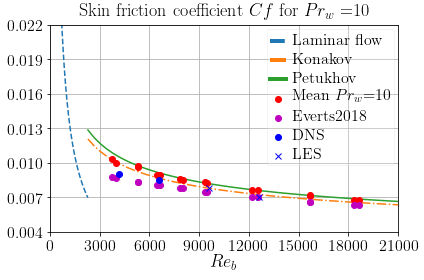

In [26]:
Re_lam = np.linspace(1,2300,)
Re_turb = np.linspace(2300,21000,)
#Skin friction for laminar flow
Cf_lam = 16 / Re_lam
#Skin friction for turbulent flow
Cf_Konakov =   0.25 * (1.8*np.log10(Re_turb) - 1.5)**(-2)
Cf_Petukhov =  0.25 * (1.8*np.log10(Re_turb) - 1.64)**(-2)

upRe = 21001
upCf = 0.0221
upNu = 201

fig = plt.figure(1)
ax1=plt.subplot(111) 
plt.xlim(100,21000)
plt.ylim(0.005,0.022)

plt.plot(Re_lam, Cf_lam, linestyle="dashed", label='Laminar flow')
plt.plot(Re_turb, Cf_Konakov,linestyle="dashdot", label="Konakov")
plt.plot(Re_turb, Cf_Petukhov,linestyle="solid", label="Petukhov")


#plt.errorbar(Re_m_samples, cf_m_samples, fmt='.', color='gray', ecolor='lightgray', alpha = 0.2, label='Samples $Pr_{w}$='+ str(prandtl))
plt.errorbar(Re_M_ave, cf_M_ave, fmt='o', color='red', ecolor='lightgray', label='Mean $Pr_{w}$='+ str(prandtl))
plt.errorbar(Re_M_ave, f, fmt='o', color='m', label='Everts2018')


plt.errorbar([4176, 6587], [0.00904, 0.00851], fmt='o', color='blue',  elinewidth=3, capsize=1, label="DNS")
plt.errorbar([9612, 12638], [0.00779, 0.00704], fmt='x', color='blue',  elinewidth=3, capsize=1, label="LES")

#plt.errorbar(Re_M_ave[17], cf_M_ave[17], fmt='X', color='orange', ecolor='lightgray', label='High heat flux')




plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.title(r'Skin friction coefficient $Cf$ for $Pr_{w}=$' + str(prandtl),fontsize=fontsize_legend+2)

ax1.xaxis.set_ticks(np.arange(0,upRe,3000))
ax1.yaxis.set_ticks(np.arange(0.004,upCf,0.003) )
leg = ax1.legend(loc='upper right',prop={'size': 8}, framealpha=0.2)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()

plt.setp(leg_lines, linewidth=linesize_legend)
plt.setp(leg_texts, fontsize=fontsize_legend)

OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + '_recf.pdf'

plt.tight_layout()
plt.savefig(OutPutFig)

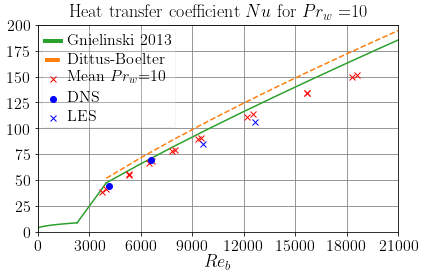

In [24]:
Pr_correlation = np.mean(Pr_w_ave)

fig = plt.figure(2)
ax1=plt.subplot(111) 
Re_lam = np.linspace(1.,2300.,)
Re_tran = np.linspace(2300.,4000.,)
Re_turb = np.linspace(4000.,100000.,)
#laminar
Nu_lam1 = 3.66
Nu_lam2 = 0.7
Nu_lam3 = 1.615 * (Re_lam * Pr_correlation * di / L)**(1./3.)
Nu_lam = (Nu_lam1**3. + Nu_lam2**3. + Nu_lam3**3.)**(1./3.)
#turbulent
xi_Kon = (0.79 * np.log10(Re_turb) - 1.64)**(-2.)#Konakov
xi_Pet = (1.8 * np.log10(Re_turb) - 1.5)**(-2.)#Petukhov
Nu_turb_Pet = ((xi_Pet/8. * Re_turb * Pr_correlation) / (1. + 12.7 * (xi_Pet/8.)**0.5 * (Pr_correlation**(2./3.) - 1.))) * (1. + (di/L)**(2./3.))
Nu_turb_Gni = ((xi_Pet/8. * Re_turb * Pr_correlation) / (1. + 12.7 * (xi_Pet/8.)**0.5 * (Pr_correlation**(2./3.) - 1.))) *(np.mean(Pr_m_ave)/np.mean(Pr_w_ave))**0.11

#xi_Pet_no_corr = (1.8 * np.log10(Re_tot) - 1.5)**(-2.)
#Nu_Gni_no_corr = ((xi_Pet_no_corr/8. * Re_tot * Pr_correlation) / (1. + 12.7 * (xi_Pet_no_corr/8.)**0.5 * (Pr_correlation**(2./3.) - 1.))) *(np.mean(Pr_m_ave)/np.mean(Pr_w_ave))**0.11

#transitional
c1 = Nu_lam[49]
c2 = Nu_turb_Gni[0]
r = (Re_tran - 2300.) / (4000. - 2300.)
Nu_tran = (1. - r) * c1 + r * c2

#Dittus_Boelter correlation
NuDB = 0.027*Re_turb**0.8 * Pr_correlation**0.4
#Entrance factor
entrance_section = 1.2
n = 2.08E-6 * Re_turb - 0.815
Nu_entrance = 1 + 23.99 * Re_turb **(-0.23) * (entrance_section / di)**n
#Roughness factor
epcylon = 3.2E-6 #assumed
Nu_roughness = 0.091 * (epcylon / di)**(-0.125) * Re_turb**(0.363*(epcylon/di)**0.1)
#Viscosity factor
Nu_viscosity = (mu_m_ave / mu_w_ave)**0.14
#Combining the four factors
Nu_Robinson = NuDB * Nu_entrance * Nu_roughness# * Nu_viscosity

plt.xlim(1000,upRe)
plt.ylim(1,200)
#Emperical correlation
plt.plot(Re_lam, Nu_lam, color='tab:green',linestyle="solid", label="Gnielinski 2013")
plt.plot(Re_tran, Nu_tran, color='tab:green',linestyle="solid")
plt.plot(Re_turb, Nu_turb_Gni, color='tab:green',linestyle="solid")
plt.plot(Re_turb, NuDB, color='tab:orange',linestyle="dashed", label="Dittus-Boelter")

#plt.errorbar(Re_m_samples, Nu_samples, delta_NuMessung_samples, fmt='.', color='gray', ecolor='lightgray',alpha=0.2, elinewidth=3, capsize=1, label='Measurement $Pr_{w}$='+ str(prandtl))
plt.errorbar(Re_M_ave, Nu_M_ave, fmt='x', color='red', ecolor='lightgray', elinewidth=3, capsize=1, label='Mean $Pr_{w}$='+ str(prandtl))
#plt.errorbar(Re_M_ave[0:8], Nu_M_ave[0:8], fmt='o', color='red', ecolor='lightgray', elinewidth=3, capsize=1, label='Mean $Pr_{w}$='+ str(prandtl)+' up')
#plt.errorbar(Re_M_ave[8:17], Nu_M_ave[8:17], fmt='x', color='red', ecolor='lightgray', elinewidth=3, capsize=1, label='Mean $Pr_{w}$='+ str(prandtl)+' down')

plt.errorbar([4176, 6587], [43.8176, 68.9527], fmt='o', color='blue',  elinewidth=3, capsize=1, label="DNS")
plt.errorbar([9612, 12638], [84.7544, 106.1393], fmt='x', color='blue',  elinewidth=3, capsize=1, label="LES")

leg = ax1.legend(loc='upper left',prop={'size': 8},framealpha=0.2)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=linesize_legend)
plt.setp(leg_texts, fontsize=fontsize_legend)

plt.grid(True,color='gray', which="both", axis='both', ls="-")
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.title (r'Heat transfer coefficient $Nu$ for $Pr_{w}=$' + str(prandtl) ,fontsize=fontsize_legend+2)


ax1.xaxis.set_ticks(np.arange(0, upRe, 3000))
ax1.yaxis.set_ticks(np.arange(0, upNu, 25))

OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + '_renu.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)

In [27]:
print('mu,%', (mu_m_ave-mu_w_ave)/mu_m_ave)
print('dT', T_w_ave - T_m_ave)
#print(Nu_M_ave)
#print(Pr_w_ave)

mu,% [0.06157007 0.04932196 0.0428096  0.03834965 0.03366645 0.02769177
 0.02283437 0.02028119 0.06225843 0.05299724 0.04390933 0.03866451
 0.0331785  0.02772981 0.02248943 0.01997319]
dT [3.56756273 2.85413708 2.47496942 2.22396407 1.94563328 1.60661839
 1.32204923 1.17277286 3.62039106 3.08429432 2.54289649 2.24127183
 1.9197677  1.60759879 1.30429797 1.15564547]


In [28]:
#DNS mu ratio
#print(mu_m_ave)
#print((mu(71.6-5.4)-mu(71.6))/mu(71.6-5.4))

In [29]:
print(Pr_w_ave)
print(Re_M_ave)
print(cf_M_ave)
print(Nu_M_ave)
print(T_w_ave)
print(T_w_ave - T_m_ave)
print((mu_m_ave-mu_w_ave)/mu_m_ave)

#print("----------------")
#print(mu_m_ave/mu_w_ave)
#print("----------------")
#print(T_m_ave/T_w_ave)
#print('------------------')


[10.00493551 10.0077451  10.01211543  9.97022818 10.00717942  9.95397753
  9.97410619  9.9864639   9.96248244  9.94292149  9.99256506  9.97566372
  9.99196652  9.96316044  9.95331593  9.97904305]
[ 3747.15461336  5347.81725574  6654.12846975  8025.89102926
  9364.88798195 12206.72401484 15668.46035614 18625.56479521
  3981.00156553  5309.10247502  6492.91115116  7832.72146041
  9507.58628679 12575.29749853 15674.06093421 18328.19004346]
[0.01032613 0.00967914 0.00891972 0.00845869 0.00828349 0.00765632
 0.00710428 0.00678348 0.00999486 0.00961278 0.00889187 0.00862733
 0.0082101  0.00760741 0.00718097 0.00677778]
[ 38.70570145  55.59465024  67.93327343  79.45573472  89.72028538
 110.67311818 133.82920785 151.58489939  41.31877994  55.17927967
  66.3855848   77.75747784  90.76210131 113.42592653 133.68090705
 149.56647705]
[71.20026157 71.18393562 71.15898849 71.3985005  71.18710384 71.4919209
 71.37624653 71.30543874 71.44312652 71.55564642 71.27054431 71.3673211
 71.27397308 71.439126

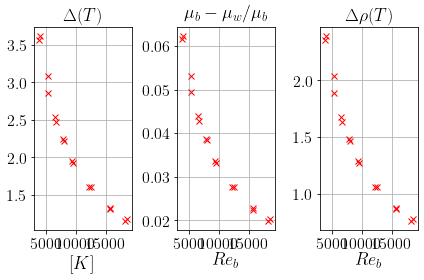

In [31]:
fig = plt.figure(3)
ax1=plt.subplot(131)
plt.plot(Re_M_ave, T_w_ave - T_m_ave,  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.xlabel(r'$[K]$',fontsize=fontsize_legend+2)
plt.title (r'$ \Delta{(T)}$' ,fontsize=fontsize_legend+2)

ax1=plt.subplot(132) 
plt.plot(Re_M_ave, (mu_m_ave-mu_w_ave)/mu_m_ave,  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
#plt.title (r'$\Delta \mu{(T)}$' ,fontsize=fontsize_legend+2)
plt.title (r'$\mu_{b}-\mu_{w}/\mu_{b}$' ,fontsize=fontsize_legend+2)

ax1=plt.subplot(133) 
plt.plot(Re_M_ave, drho_ave,  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.title (r'$\Delta \rho{(T)}$' ,fontsize=fontsize_legend+2)

OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + '_deltaT.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)

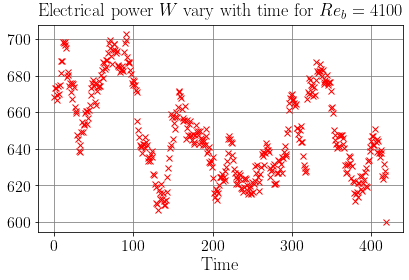

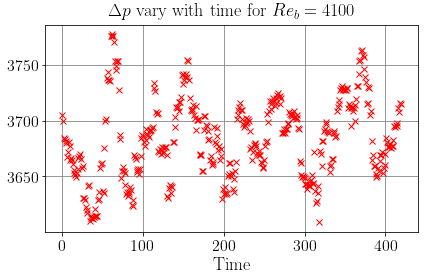

In [32]:
test = []
for i in range(420):
    test.append(i)

fig = plt.figure(3)
ax1=plt.subplot(111) 
plt.plot(test, P_MS_list, 'rx')#, label=r'$\Delta \mu{T}$')

plt.grid(True,color='gray', which="both", axis='both', ls="-")
plt.xlabel(r'Time',fontsize=fontsize_legend+2)
plt.title (r'Electrical power $W$ vary with time for $Re_{b}=4100$' ,fontsize=fontsize_legend+2)
OutPutFig = './ep_vs_pressure.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)
OutPutFig = './time_vs_w.pdf'

fig = plt.figure(4)
ax1=plt.subplot(111)  
plt.plot(test, delta_p_list,  'rx')#, label=r'$\Delta \mu{T}$')

plt.grid(True,color='gray', which="both", axis='both', ls="-")
plt.xlabel(r'Time',fontsize=fontsize_legend+2)
plt.title (r'$\Delta p$ vary with time for $Re_{b}=4100$',fontsize=fontsize_legend+2)


#plt.title (r'$\Delta p$  vs electrical power VI' ,fontsize=fontsize_legend+2)
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + '_time_vs_pressure.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)

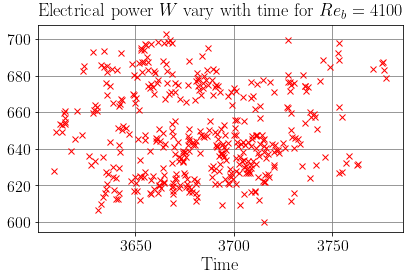

In [37]:
fig = plt.figure(4)
ax1=plt.subplot(111) 
plt.plot(delta_p_list, P_MS_list, 'rx')#, label=r'$\Delta \mu{T}$')

plt.grid(True,color='gray', which="both", axis='both', ls="-")
plt.xlabel(r'Time',fontsize=fontsize_legend+2)
plt.title (r'Electrical power $W$ vary with time for $Re_{b}=4100$' ,fontsize=fontsize_legend+2)
plt.tight_layout()
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + '_ep_vs_pressure.pdf'
plt.savefig(OutPutFig)

In [38]:
print(np.corrcoef(P_MS_list, delta_p_list))
#np.corrcoef(delta_p_list, mu_m_list)
print(np.corrcoef(delta_p_list, cf_M_list))

[[ 1.        -0.0164982]
 [-0.0164982  1.       ]]
[[1.        0.0579294]
 [0.0579294 1.       ]]


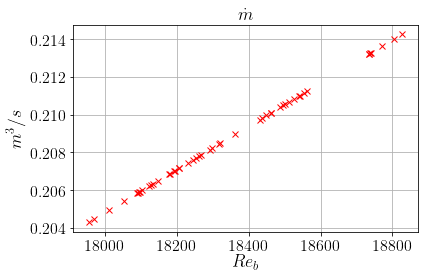

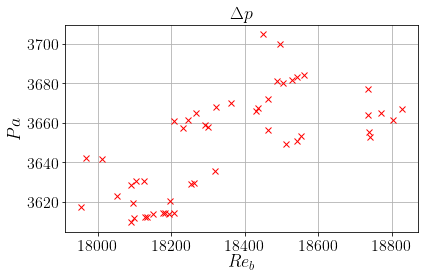

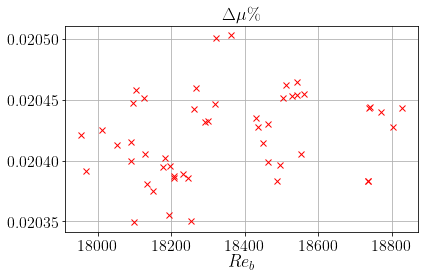

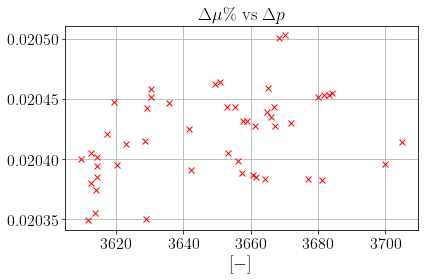

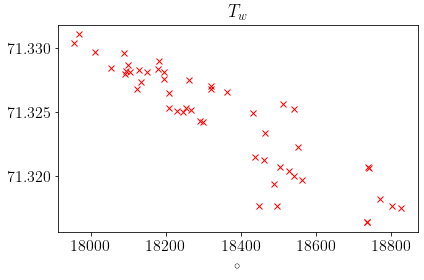

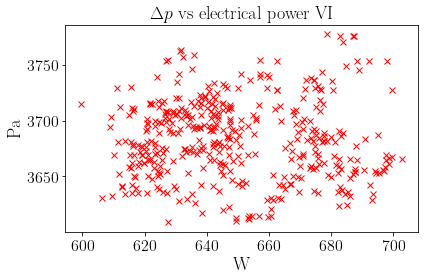

In [40]:
fig = plt.figure(4)
#ax1=plt.subplot(231) 
ax1=plt.subplot(111) 
plt.plot(Re_m_list[0:50], mdot_list[0:50],  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.ylabel(r'$m^{3} / s$',fontsize=fontsize_legend+2)
plt.title (r'$ \dot{m}$' ,fontsize=fontsize_legend+2)
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + '_re_vs_massflow.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)


fig = plt.figure(5)
ax1=plt.subplot(111) 
#ax1=plt.subplot(232) 
plt.plot(Re_m_list[0:50], delta_p_list[0:50],  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.ylabel(r'$Pa$',fontsize=fontsize_legend+2)
plt.title (r'$ \Delta p$' ,fontsize=fontsize_legend+2)
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + '_re_vs_pressure.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)


fig = plt.figure(6)
ax1=plt.subplot(111) 
#ax1=plt.subplot(233) 
plt.plot(Re_m_list[0:50], (np.asarray(mu_m_list[0:50]) - np.asarray(mu_w_list[0:50])) / np.asarray(mu_w_list[0:50])  ,  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.title (r'$ \Delta \mu \% $' ,fontsize=fontsize_legend+2)
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + '_re_vs_mu.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)


fig = plt.figure(7)
ax1=plt.subplot(111) 
#ax1=plt.subplot(234) 
plt.plot(delta_p_list[0:50], (np.asarray(mu_m_list[0:50]) - np.asarray(mu_w_list[0:50])) / np.asarray(mu_w_list[0:50]),  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Pa$',fontsize=fontsize_legend+2)
plt.xlabel(r'$[-]$',fontsize=fontsize_legend+2)
plt.title (r'$ \Delta \mu \% $ vs $ \Delta p$' ,fontsize=fontsize_legend+2)
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + '_mu_vs_pressure.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)


fig = plt.figure(8)
ax1=plt.subplot(111) 
#ax1=plt.subplot(235) 
plt.plot(Re_m_list[0:50], Tw_list[0:50],  'rx')#, label=r'$\Delta \mu{T}$')
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.xlabel(r'$^{\circ}$',fontsize=fontsize_legend+2)
plt.title (r'$ T_{w}$' ,fontsize=fontsize_legend+2)
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + '_re_vs_Tw.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)


fig = plt.figure(9)
ax1=plt.subplot(111) 
#ax1=plt.subplot(236) 
plt.plot(P_MS_list, delta_p_list,  'rx')#, label=r'$\Delta \mu{T}$')
plt.xlabel(r'W',fontsize=fontsize_legend+2)
plt.ylabel(r'Pa',fontsize=fontsize_legend+2)
plt.title (r'$\Delta p$  vs electrical power VI' ,fontsize=fontsize_legend+2)
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + '_ep_vs_pressure.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)

#Measurement 
#plt.errorbar(ReTau_list, NuMessung_list, fmt='.', color='black', ecolor='lightgray', elinewidth=3, capsize=1, label="Mesurement, Pr11.3")
#plt.errorbar(ReTau_list, Nu_turb_Gni4Tau_list, fmt='.', color='red', ecolor='lightgray', elinewidth=3, capsize=1, label="Mesurement, Pr11.3")

In [41]:

print('folders')
print(folder_names)
print('-------------')
print('Prm')
print(Pr_m_ave)
print('-------------')
print('Prw')
print(Pr_w_ave)

print(cf_M_ave)
#print(mu_m_ave)
variance = calculate_variance(cf_M_list)
std = variance**0.5
print(std)
#print(delta_cf_M_list)

folders
['/Users/yoshi/Dropbox/measurements/data/pr10_re4100_down/', '/Users/yoshi/Dropbox/measurements/data/pr10_re5400_down/', '/Users/yoshi/Dropbox/measurements/data/pr10_re6500_down/', '/Users/yoshi/Dropbox/measurements/data/pr10_re8100_down/', '/Users/yoshi/Dropbox/measurements/data/pr10_re9600_down/', '/Users/yoshi/Dropbox/measurements/data/pr10_re12600_down/', '/Users/yoshi/Dropbox/measurements/data/pr10_re15800_down/', '/Users/yoshi/Dropbox/measurements/data/pr10_re18600_down/', '/Users/yoshi/Dropbox/measurements/data/pr10_re4100_up/', '/Users/yoshi/Dropbox/measurements/data/pr10_re5400_up/', '/Users/yoshi/Dropbox/measurements/data/pr10_re6500_up_b/', '/Users/yoshi/Dropbox/measurements/data/pr10_re8100_up/', '/Users/yoshi/Dropbox/measurements/data/pr10_re9600_up/', '/Users/yoshi/Dropbox/measurements/data/pr10_re12600_up/', '/Users/yoshi/Dropbox/measurements/data/pr10_re15800_up/', '/Users/yoshi/Dropbox/measurements/data/pr10_re18600_up/']
-------------
Prm
[10.6680306  10.53222

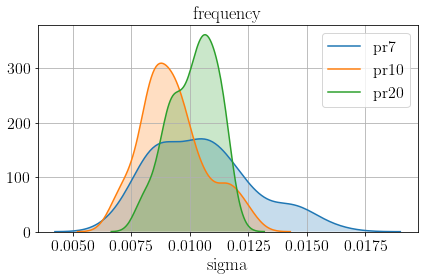

In [44]:
#Ref:https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
sns.distplot(cf_m_samples[0:192], hist=False, kde=True, rug=False, bins=40, kde_kws = {'shade': True},label='pr7')
sns.distplot(cf_m_samples[397:607], hist=False, kde=True, rug=False, bins=40, kde_kws = {'shade': True}, label='pr10')
sns.distplot(cf_m_samples[607:802], hist=False, kde=True, rug=False, bins=40, kde_kws = {'shade': True}, label='pr20')

plt.grid(True)
plt.xlabel(r'sigma',fontsize=fontsize_legend+2)
plt.title (r'frequency' ,fontsize=fontsize_legend+2)

OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + '_histgram.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)

/Users/yoshi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/yoshi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
/Users/yoshi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


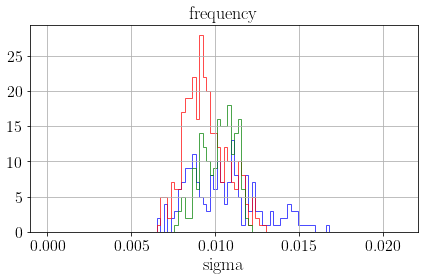

In [45]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.hist(cf_m_samples[0:192], bins=100, range = (0,0.021), normed = 0, color= 'blue',histtype = 'step',  alpha=0.7, label="pr7")
plt.hist(cf_m_samples[397:706], bins=100, range = (0,0.021), normed = 0, color= 'red',histtype = 'step',alpha=0.7, label="pr10")
plt.hist(cf_m_samples[607:802], bins=100, range = (0,0.021), normed = 0, color= 'green',histtype = 'step', alpha=0.7, label="pr20")

plt.grid(True)
plt.xlabel(r'sigma',fontsize=fontsize_legend+2)
plt.title (r'frequency' ,fontsize=fontsize_legend+2)

#plt.xlim(0,0.021)

OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + '_histgram.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)

In [ ]:
np.std(cf_m_samples[0:192])

/Users/yoshi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


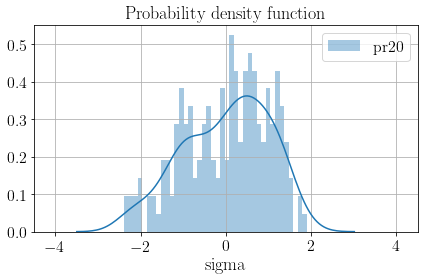

In [46]:
#Ref:https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
#sns.distplot((cf_m_samples[0:192]-np.mean(cf_m_samples[0:192]))/np.std(cf_m_samples[0:192]), hist=True, kde=True, rug=False, bins=40, label='pr7')
#sns.distplot((cf_m_samples[397:607]-np.mean(cf_m_samples[397:607]))/np.std(cf_m_samples[397:607]), hist=True, kde=True, rug=False, bins=40, label='pr10')
sns.distplot((cf_m_samples[607:802]-np.mean(cf_m_samples[607:802]))/np.std(cf_m_samples[607:802]), hist=True, kde=True, rug=False, bins=40, label='pr20')




plt.grid(True)
plt.xlabel(r'sigma',fontsize=fontsize_legend+2)
plt.title (r'Probability density function' ,fontsize=fontsize_legend+2)
plt.legend()
plt.xlim(-4.5,4.5)
#plt.ylim(0,0.025)

OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + '_pdf_pr20.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)